In [12]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [15]:
import numpy as np
import pandas as pd

In [16]:
env = gym.make("Taxi-v2")

In [17]:
class Experience:
    CURRENT_STATE = 0
    ACTION = 1
    REWARD = 2
    NEXT_STATE = 3
    DONE = 4

In [18]:
# def create_net(input_state, variable_scope, layer_list, trainable, action_num):
#     with tf.variable_scope(variable_scope):
#         w_initialiser = tf.random_normal_initializer(mean=0., stddev=0.01)
# #         layer1 = tf.layers.Dense(units=500, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable,
# #                                 kernel_initializer=w_initialiser)
# #         layer_list.append(layer1)
# #         layer1_output = layer1(input_state)
# #         layer2 = tf.layers.Dense(units=5, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable)
# #         layer_list.append(layer2)
# #         layer2_output = layer2(layer1_output)
#         output_layer = tf.layers.Dense(units=action_num, name="layer", 
#                                        trainable=trainable, kernel_initializer=w_initialiser,
#                                        activation=None
#                                       )
#         layer_list.append(output_layer)
#         output = output_layer(input_state)

#         return output
    
def create_net(input_state, variable_scope, variable_list, trainable):
    with tf.variable_scope(variable_scope):
        # =========== layer 1 ===========
        weights_1 = tf.get_variable(name="w1",
                                    initializer=tf.random_uniform([env.observation_space.n, 6],0,0.01),
                                    trainable=trainable
                                   )
        variable_list.append(weights_1)
        
        # ========== layer 2 =============
        weights_2 = tf.get_variable(name="w2",
                                    initializer=tf.random_uniform([6, env.action_space.n],0,0.01)
                                   )
        variable_list.append(weights_2)
        
        bias = tf.get_variable(name="b1",
                               shape=[6],
                               initializer=tf.constant_initializer(0.01)
                              )
        variable_list.append(bias)
        
        layer1_output = tf.nn.relu(tf.matmul(input_state, weights_1) + bias)
        output = tf.matmul(layer1_output, weights_2)
        
#         output = tf.matmul(input_state, weights_1)
        
        return output

In [19]:
def copy_net(dest_list, src_list, sess):
    for predict_variable, target_variable in zip(src_list, dest_list):
        assign_op = tf.assign(ref=target_variable, value=predict_variable)
        sess.run(assign_op)

## Create the neural network
---

In [20]:
tf.reset_default_graph()

In [21]:
predict_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype= tf.float32, name="predict_input_state")
target_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype=tf.float32, name="target_input_state")


In [22]:
predict_variable_list = []
predict_q_values_tf = create_net(predict_input_state_tf, variable_scope="predict_net",
                                 variable_list=predict_variable_list, trainable=True)

predict_action_tf = tf.argmax(predict_q_values_tf, axis=1)

In [23]:
target_variable_list = []
target_q_values_tf = create_net(target_input_state_tf, variable_scope="target_net",
                                 variable_list=target_variable_list, trainable=False)

In [24]:
y_tf = tf.placeholder(shape=(None, env.action_space.n), dtype=tf.float32)

with tf.variable_scope("loss"):
    loss_tf = tf.losses.mean_squared_error(labels=y_tf, predictions=predict_q_values_tf)

#     loss_tf = tf.reduce_sum(tf.squared_difference(y_tf, predict_q_values_tf))
with tf.variable_scope("train"):
#     my_optimiser = tf.train.GradientDescentOptimizer(2.2)
    my_optimiser = tf.train.RMSPropOptimizer(learning_rate = 0.1, momentum=0.6)
    train_op = my_optimiser.minimize(loss_tf)
#     for variables in predict_variable_list:
#         gradients_op_list.append(my_optimiser.compute_gradients(loss_tf, var_list=variables))
    grads_and_vars_op = my_optimiser.compute_gradients(loss_tf, var_list=predict_variable_list)

In [25]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

### Copy the initial network

In [26]:
copy_net(src_list=predict_variable_list, dest_list=target_variable_list, sess=sess)

In [27]:
for variable in predict_variable_list:
    predict_mat = sess.run(variable)

In [28]:
for variable in target_variable_list:
    target_mat = sess.run(variable)

In [29]:
np.unique(predict_mat - target_mat)

array([0.], dtype=float32)

## Set up hyperparameters

In [30]:
max_random_probability = 1.0
min_random_probability = 0
mem_size = 3000
update_epoches = 30
batch_size = 32
gamma = 0.99
one_hot_state = np.identity(env.observation_space.n)

## Experience replay
Create the memory

In [31]:
mem = np.zeros((mem_size, 5), dtype=np.int32)

In [32]:
def store_experience(first_start, current_state, action, reward, next_state, done):
    # index point to the oldest experience
    if first_start:
        current_idx = 0

    """
    Memory is full, replace the oldest one

    The complexity of fetching a element from deque is horrible,
    while pop the front of list is also slow(everything after 
    that must move), thus we keep track the oldest value and
    replace it since, sequence is not important(random pick)
    """
    mem[current_idx] = [current_state, action, reward, next_state, done]
    if current_idx == (mem_size - 1):  # Reach the max size
        current_idx = 0
    else:
        current_idx += 1
        
    return current_idx

## Start training the network

In [33]:
sess.run(loss_tf, feed_dict={
    y_tf: [[1,2,3,4,5,6]], 
    predict_input_state_tf: np.identity(500)[0:1]
})

15.163568

In [34]:
saver = tf.train.Saver()

In [35]:
loss_list = []
reward_list = []
steps_list = []

gradient_list = []
mean_variable_list = []
std_variable_list = []
# Always point to the oldest experience in mem

first_start = True

episode_num = 1000
random_probability_distribution = np.linspace(max_random_probability, min_random_probability, episode_num * 0.8)
learn_epochs_counter = 0

for i in range(episode_num):
    done = False
    episode_reward = 0
    current_state = env.reset()
    step_counter = 0
    random_probability = random_probability_distribution[i] if i < len(random_probability_distribution) else 0
    
    while step_counter < 100: # If agent cannot find the solution in 50 steps reset the environment
        [action], predict_q_values = sess.run([predict_action_tf, predict_q_values_tf],
                                              feed_dict={
                                                  predict_input_state_tf: one_hot_state[current_state: current_state + 1]
                                              })        
        
        if np.random.uniform() <= random_probability:
            # Randomly explore the world
            action = env.action_space.sample()
        

        # Execute the action and observe the reward
        next_state, reward, done, info = env.step(action)
        
         # Store the experience to memory
        current_idx = store_experience(
            first_start=first_start,
            current_state=current_state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done
        )
        
        if current_idx > batch_size:
            first_start = False
        
        # Randomly select batch size experiences from memory
        if first_start:
            indices = range(current_idx)
        else:
            indices = np.random.choice(mem_size, batch_size, replace=False)
        
        # Get the batch size experiences out of memory
        batch_mem = mem[indices, :]
        next_state_indices = batch_mem[:, Experience.NEXT_STATE]
        current_state_indices = batch_mem[:, Experience.CURRENT_STATE]
        
        
        # use the target network to calculate the next q values
        next_q_values = sess.run(target_q_values_tf, feed_dict={
            target_input_state_tf: one_hot_state[next_state_indices]
        })
        
        # Pick the max q value for next state
        max_next_q_value = np.max(next_q_values, axis=1)
        # Take the other actions q values
        y = predict_q_values
        # Update the right we performed only
        y[np.arange(len(y)), batch_mem[:, Experience.ACTION]] = reward + gamma * max_next_q_value
        
        # Learn
        _, grads_and_vars,loss = sess.run([train_op, grads_and_vars_op, loss_tf], feed_dict={
            predict_input_state_tf: one_hot_state[current_state: current_state + 1],
            y_tf: y
        })
        
        # Increment this after each learning
        learn_epochs_counter += 1
        
        loss_list.append(loss)
        for pair in grads_and_vars:
            gradient_list.append(np.mean(pair[0]))
            mean_variable_list.append(np.mean(pair[1]))
            std_variable_list.append(np.std(pair[1]))        
        
        
        current_state = next_state
        
        episode_reward += reward
        step_counter += 1
        
        # Update the target network every 100 learning epochs
        if learn_epochs_counter % update_epoches == 0 and learn_epochs_counter != 0:
            copy_net(src_list=predict_variable_list, dest_list=target_variable_list, sess=sess)
        
        if i > (episode_num - 5):
            env.render()
            print(loss)
            
        if done:
            break
    
    reward_list.append(episode_reward)
    steps_list.append(step_counter)
    
    if i and i%200 == 0:
        print("Episode: {0},  step: {1}, random: {2}".format(i, step_counter, random_probability))

save_path = saver.save(sess, "/obj/model.ckpt")

C:\Users\Admin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


Episode: 200,  step: 31, random: 0.7496871088861077
Episode: 400,  step: 100, random: 0.49937421777221525
Episode: 600,  step: 100, random: 0.24906132665832292
Episode: 800,  step: 100, random: 0


KeyboardInterrupt: 

## Evaluate the performance

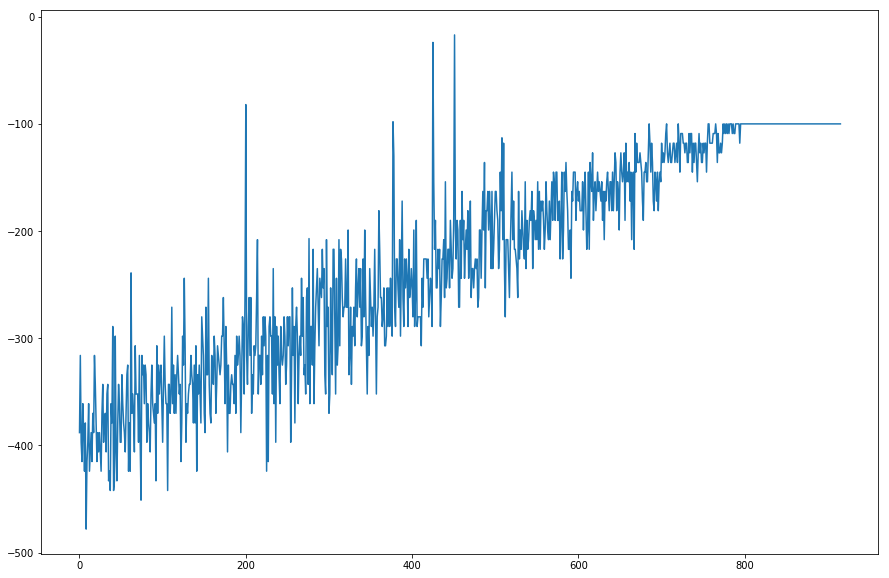

In [36]:
plt.plot(reward_list)

In [37]:
np.mean(reward_list)

-227.14192139737992

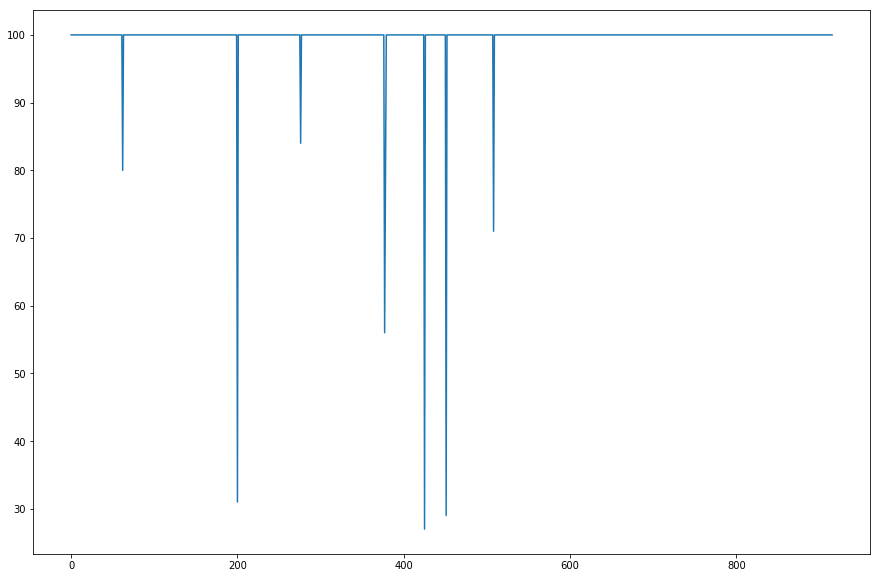

In [38]:
plt.plot(steps_list)

In [39]:
np.mean(steps_list)

99.62554585152839

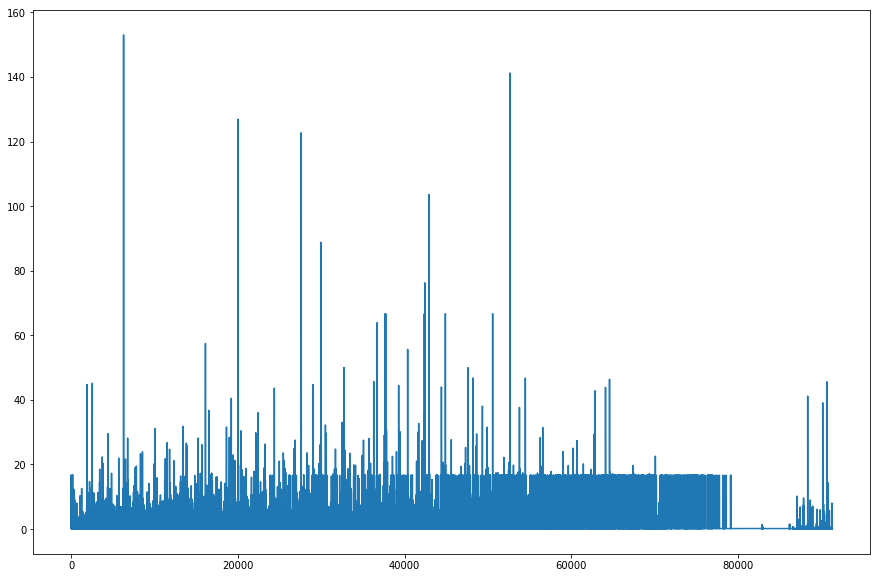

In [40]:
plt.plot(loss_list)

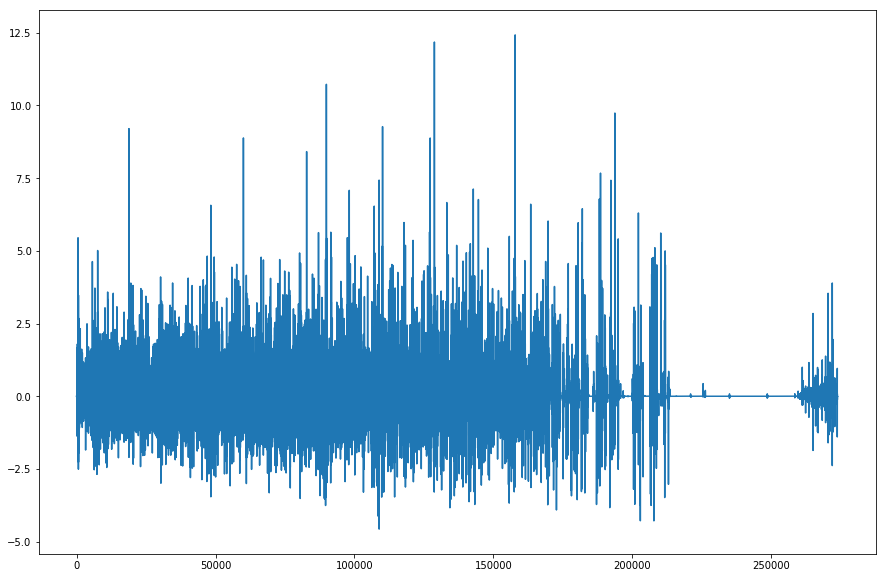

In [41]:
plt.plot(gradient_list)

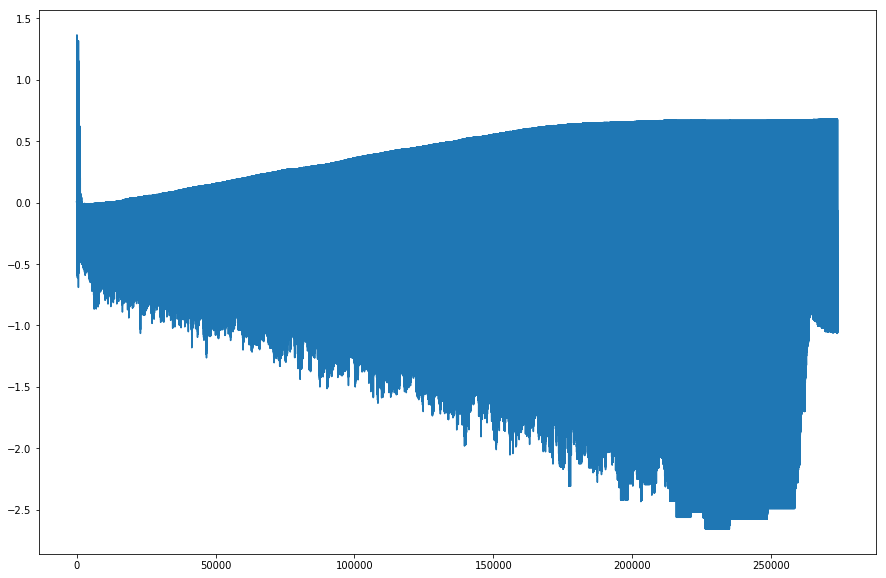

In [42]:
plt.plot(mean_variable_list)

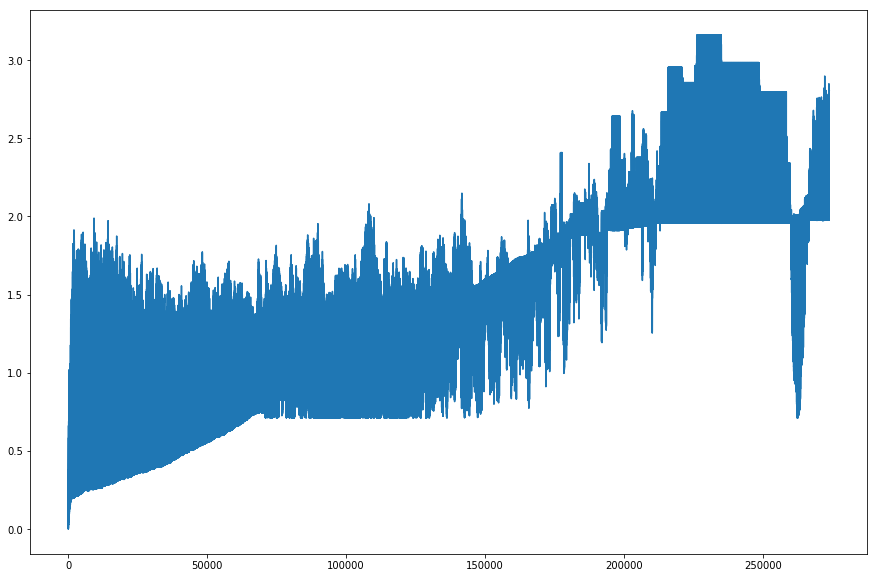

In [43]:
plt.plot(std_variable_list)

## Evaluate with the real q table

In [28]:
import pickle

q_table = pickle.load(open("obj/q_table.pkl", "rb"))

Using the `DQN` predicts the whole table

In [29]:
predict_q_table = sess.run(predict_q_values_tf, feed_dict={predict_input_state_tf: one_hot_state})

In [30]:
np.mean(np.absolute(predict_q_table - q_table))

129.33959891193763